# 深度学习方法：BERT模型

In [16]:
import numpy as np
import pandas as pd
import sys
import numpy as np
import random as rn
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from transformers import BertTokenizer, BertModel, BertForMaskedLM

### 加载数据

In [17]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
print("数据集信息：")
train_data.info()
print("————————————————")
print("数据内容概览：")
print(train_data.head())
print('得到样本：{}个'.format(train_data.shape[0]))

数据集信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
label       8000 non-null int64
question    8000 non-null object
sentence    8000 non-null object
dtypes: int64(1), object(2)
memory usage: 187.6+ KB
————————————————
数据内容概览：
   label                                    question  \
0      0    When did the third Digimon series begin?   
1      0    What famous palace is located in London?   
2      0                 Who starred in 'True Love'?   
3      0  What do most open education sources offer?   
4      1                    How is Nirvana achieved?   

                                            sentence  
0  Unlike the two seasons before it and most of t...  
1  London contains four World Heritage Sites: the...  
2  The show starred Ted Danson as Dr. John Becker...  
3  The conventional merit-system degree is curren...  
4  In Theravada Buddhism, the ultimate goal is th...  
得到样本：8000个


### 预处理数据

In [18]:
#提取question和sentence并处理成 bert的输入形式，即添加CLS和SEP
train_texts=[]
test_texts=[]
for i,row in train_data.iterrows():
    one_text='[CLS] '+row['question']+' [SEP] '+row['sentence']+' [SEP]'
    train_texts.append(one_text)
for i,row in test_data.iterrows():
    one_text='[CLS] '+row['question']+' [SEP] '+row['sentence']+' [SEP]'
    test_texts.append(one_text)
train_labels=list(train_data.label)

print(test_texts[0])
print(train_texts[0])

[CLS] What was Beringia? [SEP] According to the prevailing theories of the settlement of the Americas, migrations of humans from Asia (in particular North Asia) to the Americas took place via Beringia, a land bridge which connected the two continents across what is now the Bering Strait. [SEP]
[CLS] When did the third Digimon series begin? [SEP] Unlike the two seasons before it and most of the seasons that followed, Digimon Tamers takes a darker and more realistic approach to its story featuring Digimon who do not reincarnate after their deaths and more complex character development in the original Japanese. [SEP]


### 对文本进行tokenize

In [19]:
#tokenize 上面得到的text
#这里要尽量用好的网络，否则会提示匹配不到model name，参考transformer 的github项目的issue
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

tokenized_train_texts=[tokenizer.tokenize(sent)[:512] for sent in train_texts]
tokenized_test_texts=[tokenizer.tokenize(sent)[:512] for sent in test_texts]

print("tokenized的第一句话:",tokenized_train_texts[0])

tokenized的第一句话: ['[CLS]', 'when', 'did', 'the', 'third', 'dig', '##imo', '##n', 'series', 'begin', '?', '[SEP]', 'unlike', 'the', 'two', 'seasons', 'before', 'it', 'and', 'most', 'of', 'the', 'seasons', 'that', 'followed', ',', 'dig', '##imo', '##n', 'tame', '##rs', 'takes', 'a', 'darker', 'and', 'more', 'realistic', 'approach', 'to', 'its', 'story', 'featuring', 'dig', '##imo', '##n', 'who', 'do', 'not', 'rein', '##car', '##nate', 'after', 'their', 'deaths', 'and', 'more', 'complex', 'character', 'development', 'in', 'the', 'original', 'japanese', '.', '[SEP]']


### 将每一个token转换为词典里的id

In [20]:
#将每个text中的token转换为  tokenizer vocabulary的id
train_tokens_ids=[tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_train_texts]
test_tokens_ids=[tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_test_texts]

print("转化后的第一个句子:",train_tokens_ids[0])

转化后的第一个句子: [101, 2043, 2106, 1996, 2353, 10667, 16339, 2078, 2186, 4088, 1029, 102, 4406, 1996, 2048, 3692, 2077, 2009, 1998, 2087, 1997, 1996, 3692, 2008, 2628, 1010, 10667, 16339, 2078, 24763, 2869, 3138, 1037, 9904, 1998, 2062, 12689, 3921, 2000, 2049, 2466, 3794, 10667, 16339, 2078, 2040, 2079, 2025, 27788, 10010, 12556, 2044, 2037, 6677, 1998, 2062, 3375, 2839, 2458, 1999, 1996, 2434, 2887, 1012, 102]


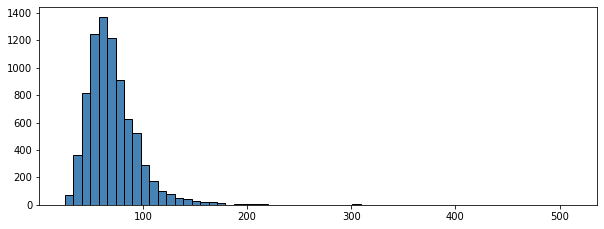

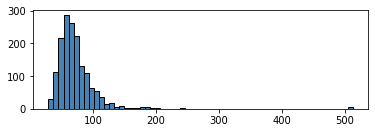

In [38]:
import matplotlib.pyplot as plt
len_list_for_train=[]
len_list_for_test=[]
for id in train_tokens_ids:
    len_list_for_train.append(len(id))
for id in test_tokens_ids:
    len_list_for_test.append(len(id))
#通过绘制直方图可以看出，绝大部分句子tokenize之后的长度都在200左右，故统一长度都为220
figure = plt.figure('直方图均衡化',figsize=(10,8))         
plt.subplot(2,1,1) 
plt.hist(x = len_list_for_train, # 指定绘图数据
          bins = 60, # 指定直方图中条块的个数
          color = 'steelblue', # 指定直方图的填充色
          edgecolor = 'black' # 指定直方图的边框色
          )
plt.show()
plt.subplot(2,1,2) 
plt.hist(x = len_list_for_test, # 指定绘图数据
          bins = 60, # 指定直方图中条块的个数
          color = 'steelblue', # 指定直方图的填充色
          edgecolor = 'black' # 指定直方图的边框色
          )
plt.show()

### 对数据进行填充和截断，可以使用keras里的pad_sequence

In [47]:
# 对数据进行填充或截断，使输入都有一样的长度220
for id in train_tokens_ids:
    while(len(id)>220):
        id.pop()
    while(len(id)<220):
        id.append(0)

for id in test_tokens_ids:
    while(len(id)>220):
        id.pop()
    while(len(id)<220):
        id.append(0)


In [62]:
test_labels=list(test_data.label)

### 模型构建

In [66]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

### 尝试将模型放在GPU上进行训练，但是GPU显存不足，导致无法继续进行

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [79]:
#查看分配了多少GPU的空间
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'3063.243776M'

In [69]:
#将模型放在GPU上
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

In [70]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'878.137856M'

In [71]:
torch.cuda.empty_cache()

In [55]:
BATCH_SIZE = 4  #批处理量大小
EPOCHS = 10    #迭代轮数

In [64]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_label_tensor = torch.tensor(np.array(train_labels).reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_label_tensor = torch.tensor(np.array(test_labels).reshape(-1, 1)).float()

train_dataset = TensorDataset(train_tokens_tensor, train_label_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_label_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [80]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)
bert_clf.train()
for epoch_num in range(EPOCHS):
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, labels = tuple(t.to(device) for t in batch_data)
        probas = bert_clf(token_ids)
        loss_func = nn.BCELoss()
        batch_loss = loss_func(probas, labels)
        bert_clf.zero_grad()
        batch_loss.backward()
        optimizer.step()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.86 GiB already allocated; 19.16 MiB free; 3.02 GiB reserved in total by PyTorch)